In [16]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from tensorflow.keras import metrics
import scipy.stats as stats
import itertools

In [17]:
def ctc_label_dense_to_sparse(labels, label_lengths):
    """
    Converts dense labels to sparse representation for CTC loss calculation.
    Args:
    - labels (tensor): Dense representation of labels.
    - label_lengths (tensor): Length of each label.
    Returns:
    - SparseTensor: Sparse representation of labels.
    """
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])
    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )
    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]
    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)
    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )
    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64")
    )

In [18]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    """
    Computes the Connectionist Temporal Classification (CTC) loss for a batch of predictions.
    Args:
    - y_true (tensor): True labels.
    - y_pred (tensor): Predicted labels.
    - input_length (tensor): Length of the input sequence.
    - label_length (tensor): Length of the true labels.
    Returns:
    - tensor: Batch-wise CTC loss.
    """
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

In [19]:
@keras.saving.register_keras_serializable(package="customs", name="CTCLayer")
class CTCLayer(layers.Layer):
    """
    Custom Keras layer for calculating CTC loss.
    Args:
    - trainable (bool): Whether the layer is trainable.
    - dtype (str): Data type of the layer.
    - name (str): Name of the layer.
    """
    def __init__(self, trainable=True, dtype='float32', name=None, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, name=name, **kwargs)
        self.loss_fn = ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")
        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [20]:
def levenshtein(s1, s2):
    """
    Computes the Levenshtein distance between two strings.

    Args:
    - s1 (str): First string.
    - s2 (str): Second string.

    Returns:
    - int: Levenshtein distance between the strings.
    """
    dp = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j
    
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(dp[i - 1][j] + 1,
                        dp[i][j - 1] + 1,
                        dp[i - 1][j - 1] + cost)
    return dp[len(s1)][len(s2)]


In [21]:
def scale_image(scaller):
    global img_width, img_height
    """
    Scales the image dimensions based on the provided scaling factor.
    Args:
    - scaller (float): Scaling factor for image dimensions.
    """
    img_width = int(200 * scaller)
    img_height = int(40 * scaller)

In [22]:
def split_data(images, labels, train_size=0.8, valid_size=0.1, test_size=0.1, shuffle=True, random_state=None):
    """
    Splits the dataset into training, validation, and test sets.
    Args:
    - images (list): List of image file paths.
    - labels (list): List of corresponding labels.
    - train_size (float): Proportion of data to include in the training set.
    - valid_size (float): Proportion of data to include in the validation set.
    - test_size (float): Proportion of data to include in the test set.
    - shuffle (bool): Whether to shuffle the data before splitting.
    - random_state (int): Seed for random number generation.
    Returns:
    - tuple: Splits of training, validation, and test datasets.
    """
    size = len(images)
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(size)
    else:
        indices = np.arange(size)
    train_samples = int(size * train_size)
    valid_samples = int(size * valid_size)
    test_samples = int(size * test_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples + valid_samples]], labels[indices[train_samples:train_samples + valid_samples]]
    x_test, y_test = images[indices[train_samples:train_samples + test_samples:]], labels[indices[train_samples:train_samples + test_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [23]:
def ctc_decode2(y_pred):
    """
    Decodes the predicted labels using the CTC decoding algorithm.

    Args:
    - y_pred (tensor): Predicted labels.

    Returns:
    - tuple: Tuple containing the decoded labels and their log probabilities.
    """
    input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]  # Tutaj zamiast y_pred było preds. Przyobserwować!
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
        inputs=y_pred, sequence_length=input_length
    )

    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))

    dec = (decoded_dense, log_prob)

    return dec

In [24]:
def decode_to_utf8(y_pred, charst):
    """
    Decodes the predicted labels to UTF-8 format.

    Args:
    - y_pred (numpy.ndarray): Predicted labels.

    Returns:
    - list: List of decoded labels in UTF-8 format.
    """
    y_pred = np.where(y_pred == -1, 1, y_pred)
    decoded_text_numpy = np.array(charst)
    decoded_text_utf8 = np.char.decode(decoded_text_numpy.astype('bytes'), 'utf-8')

    res_words = [''.join(filter(lambda x: x != ' ', row)) for row in decoded_text_utf8]

    return res_words

In [25]:
def model_full(scaller,normalization,filter_size,activation):
    """
    Builds and trains a handwritten text recognition model using Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs).

    Args:
    - scaller (float): Scaling factor for image dimensions.
    - normalization (str): Type of image normalization. Supported options are 'zscore' and 'minmax'.
    - filter_size (int): Size of the convolutional filters.
    - activation (str): Activation function used in the convolutional layers.

    Returns:
    - float: Average Levenshtein Distance between predicted and true labels.
    """

    #     global data_dir, train_csv, images, characters , max_length , labels, char_to_num, num_to_char

    data_dir = "./data/test_v2/test/"
    train_csv = pd.read_csv('./data/written_name_test_v2.csv')

    train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
    train_csv = train_csv[train_csv['IDENTITY'] != 'BLANK']
    train_csv = train_csv.sample(frac=0.001, random_state=42)

    images = list(train_csv['FILENAME'])
    labels = list(train_csv['IDENTITY'].astype(str))
    train_csv = train_csv.dropna(subset=['IDENTITY'])

    images = [os.path.join(data_dir, img) for img in images]

    characters = set(char for label in labels if isinstance(label, str) for char in label)
    characters = sorted(list(characters))

    batch_size = 16
    img_width = 200
    img_height = 40
    downsample_factor = 4
    max_length = max([len(str(label)) for label in train_csv['IDENTITY']])
    labels = [label.ljust(max_length) for label in labels]


    char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

    x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

    def encode_single_sample(img_path, label, scaller, normalization):
        """
        Encodes a single image-label pair for training the model.

        Args:
        - img_path (str): File path of the image.
        - label (str): Label corresponding to the image.
        - scaller (float): Scaling factor for image dimensions.
        - normalization (str): Type of image normalization.

        Returns:
        - dict: Dictionary containing the encoded image and label.
        """
        img = tf.io.read_file(img_path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        scale_image(scaller)
        img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img = ops.transpose(img, axes=[1, 0, 2])
        if normalization == "zscore":
            img = tf.image.per_image_standardization(img)
        elif normalization == "minmax":
            img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        return {"image": img, "label": label}

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (
        train_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    validation_dataset = (
        validation_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_dataset = (
        test_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()

    def build_model(num_conv_layers=2, filter_size=3, activation='tanh'):
        """
        Builds the OCR model consisting of CNN and RNN layers.

        Args:
        - num_conv_layers (int): Number of convolutional layers.
        - filter_size (int): Size of the convolutional filters.
        - activation (str): Activation function used in the convolutional layers.

        Returns:
        - keras.models.Model: Compiled OCR model.
        """
        input_img = layers.Input(
            shape=(img_width, img_height, 1), name="image", dtype="float32"
        )
        labels = layers.Input(name="label", shape=(None,), dtype="float32")

        x = input_img
        for i in range(num_conv_layers):
            x = layers.Conv2D(
                64,
                (filter_size, filter_size),
                activation=activation,
                kernel_initializer="he_normal",
                padding="same",
                name=f"Conv{i+1}",
            )(x)
            x = layers.MaxPooling2D((2, 2), name=f"pool{i+1}")(x)

        downscale_factor = 2 ** num_conv_layers
        new_shape = ((img_width // downscale_factor), (img_height // downscale_factor) * 64)    
        x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
        x = layers.Dense(64, activation="relu", name="dense1")(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(
            len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
        )(x)

        output = CTCLayer(name="ctc_loss")(labels, x)

        model = keras.models.Model(
            inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
        )

        opt = keras.optimizers.Adam()
        model.compile(optimizer=opt)
        return model


    # Get the model
    model = build_model(filter_size=filter_size, activation=activation)
    # model.summary()

    epochs = 3
    early_stopping_patience = 10
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

    preds = model.predict(test_dataset)



    dec = ctc_decode2(preds)[0][0][:, :max_length]
    print(dec.shape)
    # res = decode_to_utf8(dec)
    # print(res)

    for batch in test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

    print(len(batch_images))
    print(len(batch_labels))

    prediction_model = keras.models.Model(
        model.input[0], model.get_layer(name="dense2").output
    )
    # prediction_model.summary()
    #  Let's check results on some validation samples
    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        # pred_texts = decode_batch_predictions(preds)

        dec = ctc_decode2(preds)[0][0][:, :max_length]
        pred_texts = decode_to_utf8(dec, num_to_char(dec))
        # pred_texts = pred_texts.astype(str)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}\nReal: {orig_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()

    total_distance = 0
    num_samples = 0
    for batch in validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        dec = ctc_decode2(preds)[0][0][:, :max_length]
        pred_texts = decode_to_utf8(dec, num_to_char(dec))
        
        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        for i in range(len(pred_texts)):
            total_distance += levenshtein(pred_texts[i], orig_texts[i])
            num_samples += 1


    # Calculate and print the average Levenshtein distance
    average_distance = total_distance / num_samples
    print(f"Average Levenshtein Distance: {average_distance}")
    return average_distance


In [26]:
def t_test(results):
    """
    Performs the t-student test on the results of different combinations.

    Args:
    - results (dict): Dictionary containing combinations as keys and their corresponding results as values.

    Returns:
    - None
    """
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination: {best_combination}, Best result: {best_result}")
    
    for combination, result in results.items():
        if combination != best_combination:
            statistic, p_value = stats.ttest_rel(results[best_combination], result)
            if p_value < 0.05:  # Przyjmujemy poziom istotności 0.05
                print(f"Combination {combination} is significantly different from the best combination.")
            else:
                print(f"No significant difference found for combination {combination}.")


In [27]:
def experiment_preprocessing():
    """
    Experiment 1: Preprocessing Image Techniques.

    This function performs an experiment on preprocessing image techniques, 
    evaluating the effect of different scaling factors and normalization methods.

    Returns:
    - best_combination (tuple): Best combination of preprocessing techniques.
    """
    results = {}
    scaling_factors = [0.5, 1.0, 1.5]
    normalizations = ["zscore", "minmax"]

    preprocessing_combinations = list(itertools.product(scaling_factors, normalizations))

    for combination in preprocessing_combinations:
        scaling_factor, normalization = combination
        
        # Display current combination
        print(f"Preprocessing combination: Scaling factor: {scaling_factor}, Normalization: {normalization}")
        result = model_full(scaling_factor, normalization, 3, 'tanh')
        results[combination] = result

    print("Results:")
    for combination, result in results.items():
        print(f"Combination: {combination}, Average Distance: {result}")

    # Find the best result (minimum Levenshtein distance)
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination from Experiment 1: {best_combination}, Best result: {best_result}")
    t_test(results)
    return best_combination

def experiment_hyperparameters(best_combination):
    """
    Experiment 2: Hyperparameter Optimization.

    This function performs an experiment on hyperparameter optimization,
    evaluating the effect of different filter sizes and activation functions.

    Args:
    - best_combination (tuple): Best combination of preprocessing techniques from Experiment 1.

    Returns:
    - best_combination (tuple): Best combination of hyperparameters.
    """
    results = {}
    filter_sizes = [5, 10, 15]
    activations = ["tanh", "relu", "sigmoid", "softmax"]

    hyperparameter_combinations = list(itertools.product(filter_sizes, activations))

    for combination in hyperparameter_combinations:
        filter_size, activation = combination
        
        # Display current combination
        print(f"Hyperparameter combination: Number of Conv Layers: Filter Size: {filter_size}, Activation: {activation}")
        result = model_full(best_combination[0], best_combination[1], filter_size, activation)
        results[combination] = result

    print("Results:")
    for combination, result in results.items():
        print(f"Combination: {combination}, Average Distance: {result}")

    # Find the best result (minimum Levenshtein distance)
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination from Experiment 2: {best_combination}, Best result: {best_result}")
    t_test(results)
    return best_combination

def experiment_model_evaluation(best_combination1, best_combination2):
    """
    Evaluates the performance of the OCR model based on the best combinations 
    obtained from previous experiments.

    Parameters:
    - best_combination1 (tuple): A tuple containing the best combination of preprocessing parameters 
                                  obtained from Experiment 1.
    - best_combination2 (tuple): A tuple containing the best combination of hyperparameters 
                                  obtained from Experiment 2.

    Returns:
    - accuracy_percentage (float): The accuracy of the OCR model expressed as a percentage.

    This function evaluates the OCR model's performance by training and testing the model 
    using the best combinations of preprocessing parameters and hyperparameters obtained 
    from previous experiments. It calculates the accuracy of the model based on the Levenshtein 
    distance between predicted and actual text, and then converts it into a percentage.

    Example:
    ```
    best_combination1 = (0.5, "zscore")
    best_combination2 = (10, "relu")
    accuracy_percentage = experiment_model_evaluation(best_combination1, best_combination2)
    print(f"Model Accuracy: {accuracy_percentage:.2f}%")
    ```
    """
    # Extracting best combinations
    scaller, normalization = best_combination1
    filter_size, activation = best_combination2

    # Evaluating model performance
    average_distance = model_full(scaller, normalization, filter_size, activation)

    # Calculating accuracy percentage
    accuracy = 1 - (average_distance / max_length)
    accuracy_percentage = accuracy * 100

    # Displaying results
    print("Model Evaluation Results:")
    print(f"Accuracy: {accuracy_percentage:.2f}%")

    return accuracy_percentage


Experiment 1: Preprocessing Image Techniques
Preprocessing combination: Scaling factor: 0.5, Normalization: zscore


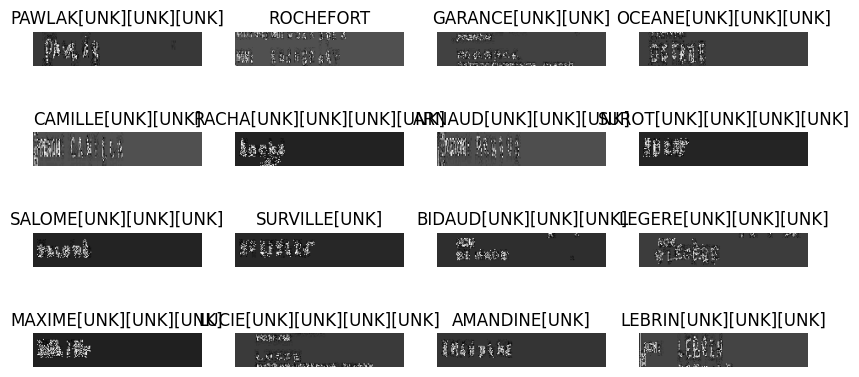

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - loss: 2001.2802 - val_loss: 319.1596
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1228.4969 - val_loss: 197.1334
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 800.2288 - val_loss: 155.4144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
(4, 9)
4
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


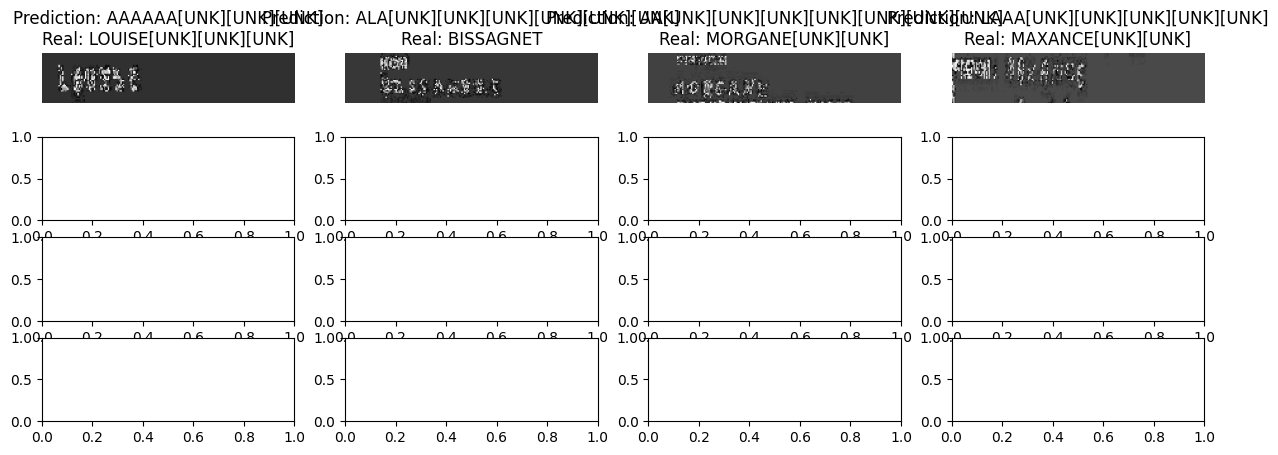

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Average Levenshtein Distance: 20.0
Preprocessing combination: Scaling factor: 0.5, Normalization: minmax


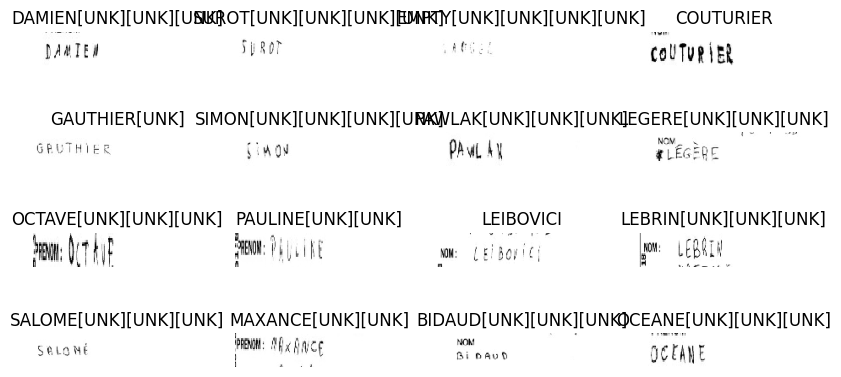

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 1728.9623 - val_loss: 177.0836
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 1018.8351 - val_loss: 170.2289
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 980.2374 - val_loss: 158.3574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
(4, 9)
4
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


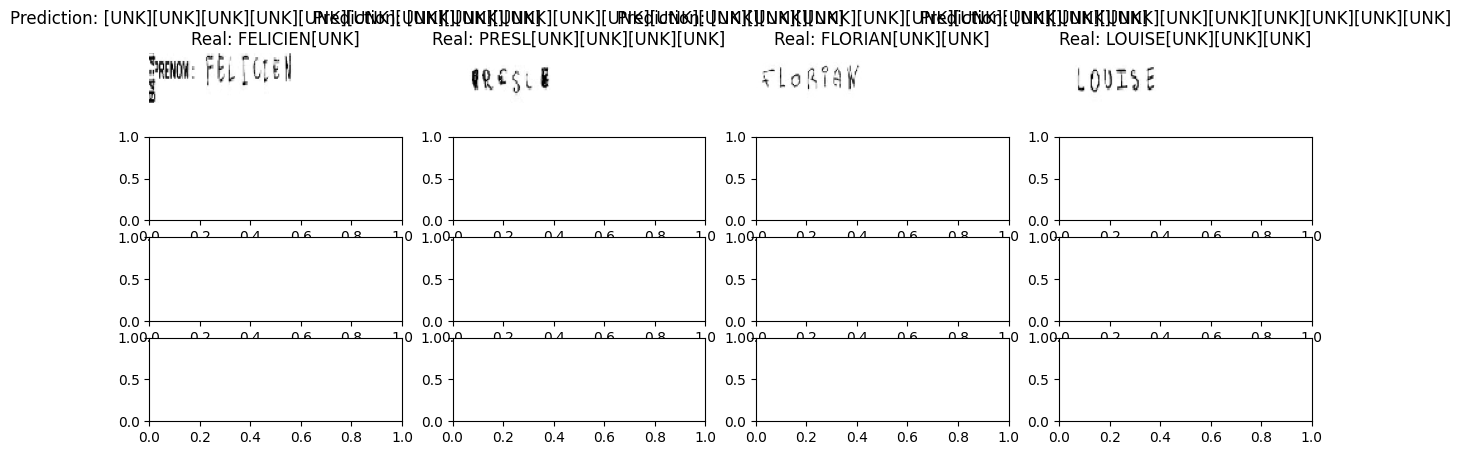

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Average Levenshtein Distance: 31.75
Preprocessing combination: Scaling factor: 1.0, Normalization: zscore


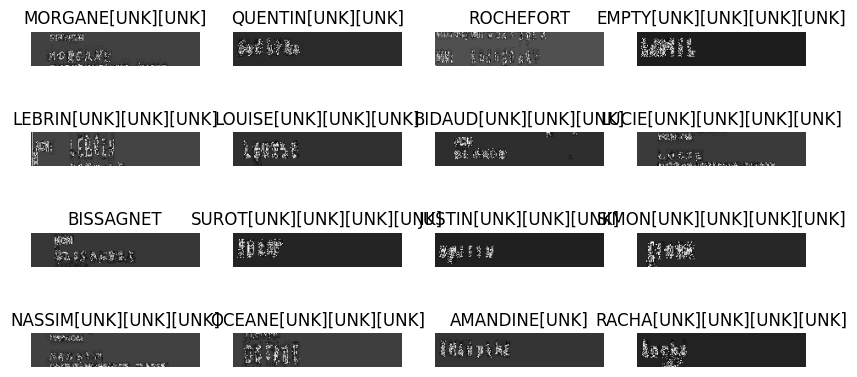

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - loss: 1757.6410 - val_loss: 226.1267
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 865.8593 - val_loss: 129.6433
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 561.2320 - val_loss: 145.4142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
(4, 9)
4
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [28]:
# Run experiments
print("Experiment 1: Preprocessing Image Techniques")
best_combination1 = experiment_preprocessing()

print("\nExperiment 2: Hyperparameter Optimization")
best_combination2 = experiment_hyperparameters(best_combination1)

print("\nExperiment 3: Model Evaluation")
accuracy_percentage = experiment_model_evaluation(best_combination1, best_combination2)